In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
df=pd.read_csv('Hotel_Review_Sentiment_analysis.csv')

In [3]:
df.keys()

Index(['Hotel_Address', 'Additional_Number_of_Scoring', 'Review_Date',
       'Average_Score', 'Hotel_Name', 'Reviewer_Nationality',
       'Negative_Review', 'Review_Total_Negative_Word_Counts',
       'Total_Number_of_Reviews', 'Positive_Review',
       'Review_Total_Positive_Word_Counts',
       'Total_Number_of_Reviews_Reviewer_Has_Given', 'Reviewer_Score', 'Tags',
       'days_since_review', 'lat', 'lng', 'pos_score', 'neg_score'],
      dtype='object')

In [40]:
# Fix empty nationality
df['Reviewer_Nationality']=df['Reviewer_Nationality'].replace(' ','Not Specified')
df.sort_values('Reviewer_Nationality').head(3)

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng,pos_score,neg_score
286694,Bergara 8 Eixample 08002 Barcelona Spain,256,5/11/2017,8.8,Hotel Pulitzer,Abkhazia Georgia,No Negative,0,1746,Ease of access to and from hotel Friendly hot...,12,1,8.3,"[' Business trip ', ' Group ', ' Double or Twi...",84,41.386136,2.168291,0.0,0.0
335518,Gudrunstra e 184 10 Favoriten 1100 Vienna Austria,191,7/12/2016,8.2,Rainers Hotel Vienna,Abkhazia Georgia,All was grat more than ours expectation D,9,1852,Room was comfort clean modern and hotel crew ...,15,1,10.0,"[' Leisure trip ', ' Couple ', ' Superior Twin...",387,48.179189,16.362537,0.0,0.0
191007,44 Grosvenor Square Westminster Borough London...,806,1/11/2017,7.8,Millennium Hotel London Mayfair,Abkhazia Georgia,Bathroom need to be changed,6,3117,No Positive,0,1,6.3,"[' Leisure trip ', ' Family with young childre...",204,51.510574,-0.150995,0.0,0.0


In [67]:
# Dealing with users in order to create a reccomandation system
#
users=pd.DataFrame(df[['Reviewer_Nationality','Total_Number_of_Reviews_Reviewer_Has_Given',\
                       'Reviewer_Score','pos_score', 'neg_score']])
users=users.groupby(['Reviewer_Nationality','Total_Number_of_Reviews_Reviewer_Has_Given'], as_index=False)\
.agg({'Reviewer_Score':['min','max','mean'],'neg_score':['min','max','mean'],'pos_score':['min','max','mean']})
users.columns = users.columns.map('_'.join)
users.head(3)

,Reviewer_Nationality_,Total_Number_of_Reviews_Reviewer_Has_Given_,Reviewer_Score_min,Reviewer_Score_max,Reviewer_Score_mean,neg_score_min,neg_score_max,neg_score_mean,pos_score_min,pos_score_max,pos_score_mean
0,Abkhazia Georgia,1,3.3,10.0,8.442424,0.0,929.9,38.969697,0.0,198.0,14.833333
1,Abkhazia Georgia,2,2.9,10.0,8.087500,0.0,1376.1,73.583333,0.0,69.9,2.912500
2,Abkhazia Georgia,3,6.3,10.0,9.155556,0.0,0.0,0.000000,0.0,155.6,21.611111


In [68]:
users['Reviewer_Nationality_cat']=users['Reviewer_Nationality_'].copy().astype('category')
users['Rev_Nat_cat']=users['Reviewer_Nationality_cat'].copy().cat.codes

In [69]:
# Here we do a false assumption that each country and number of reviews define a single reviewer
# for the sake ok having a list of users to work with
users=users.drop('Reviewer_Nationality_',1).drop_duplicates()\
.sort_values('Total_Number_of_Reviews_Reviewer_Has_Given_',ascending=False)

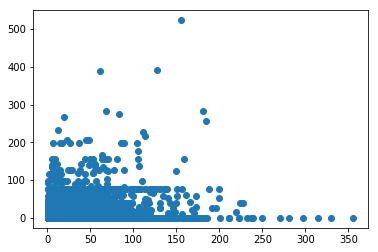

In [80]:
plt.scatter(users['Total_Number_of_Reviews_Reviewer_Has_Given_'],users['pos_score_mean'])

In [101]:
df['tot_score']=df['pos_score'].copy()-df['neg_score'].copy()

In [124]:
np.round(df.groupby('Hotel_Name').agg({'tot_score':'mean','pos_score': 'mean',\
                                      'neg_score': 'mean','Average_Score':'mean','date':'max'})\
         .sort_values('tot_score',ascending=False).head(10), decimals=2)

,tot_score,pos_score,neg_score,Average_Score,date
Hotel_Name,,,,,
Hollmann Beletage Design Boutique,37.87,41.28,3.41,9.3,2017-08-01
Small Luxury Hotel Altstadt Vienna,36.91,40.88,3.96,9.3,2017-08-03
Hotel The Serras,35.51,41.82,6.31,9.6,2017-08-03
COMO The Halkin,34.88,34.88,0.00,9.3,2017-07-05
Milestone Hotel Kensington,34.24,36.12,1.88,9.5,2017-08-02
Hotel Neri,34.03,45.28,11.25,9.2,2017-07-27
Hotel Casa Camper,33.56,38.16,4.60,9.6,2017-08-03
Palais Coburg Residenz,32.68,41.59,8.91,9.5,2017-07-03
45 Park Lane Dorchester Collection,32.33,32.33,0.00,9.4,2017-07-22


In [120]:
# Slow running
from dateutil import parser
date=[]
for i in range(len(df)):
    date.append(parser.parse(df['Review_Date'][i]))
df['date']=date